<a href="https://www.kaggle.com/code/arihant18/covid-detection?scriptVersionId=181321665" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from tensorflow.keras.utils import image_dataset_from_directory
import keras
from keras.applications import VGG19
from keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day4.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day0.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig2.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PN

2024-06-03 18:19:56.968282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 18:19:56.968401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 18:19:57.226730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train='/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train/'
test ='/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/'

In [3]:
train_ds =image_dataset_from_directory(train,
                                       batch_size=148
                                      )
test_ds =image_dataset_from_directory(test,
                                      batch_size=40
                                      )

Found 148 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


In [4]:
single_batch = train_ds.as_numpy_iterator().next()
train_x, train_y = single_batch[0]/255, single_batch[1]
print(train_x.shape, train_y.shape)

single_batch = test_ds.as_numpy_iterator().next()
test_x, test_y = single_batch[0]/255, single_batch[1]
print(test_x.shape, test_y.shape)

(148, 256, 256, 3) (148,)
(40, 256, 256, 3) (40,)


In [5]:
label=os.listdir(train)
label

['PNEUMONIA', 'NORMAL']

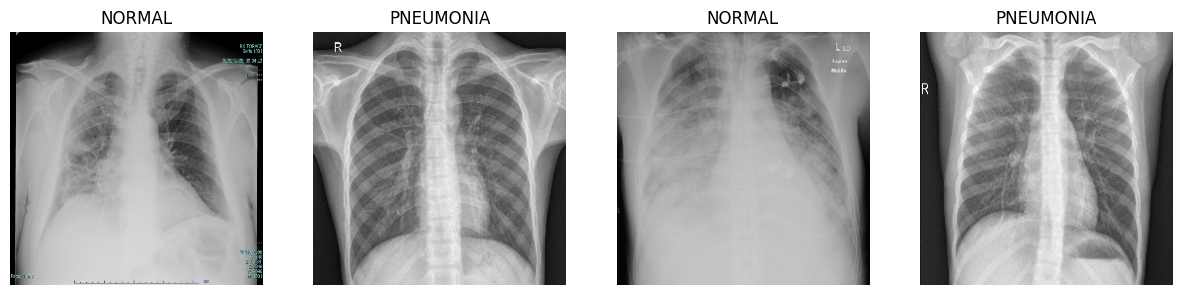

In [6]:
fig, ax = plt.subplots(1,4, figsize=(15,15))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(train_x[i])
    ax[i].set_title(label[train_y[i]])

In [7]:
vgg = VGG19(include_top=False, input_shape=train_x[0].shape)
vgg.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
for layer in vgg.layers:
    layer.trainable = False
print("Number of trainable parameters:",len(vgg.trainable_variables))

Number of trainable parameters: 0


In [9]:
from keras import Model

X = Flatten()(vgg.output)
X = Dense(128, activation='relu')(X)
output = Dense(1, activation='sigmoid')(X)
model = Model(vgg.input, output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           12

 Total params: 24,218,945 (92.39 MB)

 Trainable params: 4,194,561 (16.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [10]:
adam = keras.optimizers.Adam(0.01)
loss = keras.losses.BinaryCrossentropy()

model.compile(loss=loss, optimizer= adam)

In [11]:
History=model.fit(
            train_x, 
            train_y, 
            batch_size=64, 
            epochs = 30,
            validation_data = (test_x, test_y)         
                 ).history

Epoch 1/30


2024-06-03 18:21:26.954861: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[64,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,512,32,32]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-03 18:21:27.032632: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.077897735s
Trying algorithm eng12{k11=2} for conv (f32[64,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,512,32,32]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is takin

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 44.9181  

W0000 00:00:1717438921.952632     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717438973.419790     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 154s 39s/step - loss: 49.9484 - val_loss: 17.5245
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 410ms/step - loss: 22.1867 - val_loss: 15.1347
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step - loss: 13.5959 - val_loss: 7.6573
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step - loss: 8.4641 - val_loss: 8.9059
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - loss: 6.3075 - val_loss: 0.0622
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - loss: 0.7047 - val_loss: 1.6833
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - loss: 3.1624 - val_loss: 0.5202
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step - loss: 0.8273 - val_loss: 0.1328
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step - loss: 0.2086 - val_loss: 1.5586
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step - loss: 0.7011 - val_loss: 1.7652
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - loss: 0.5406 - val_loss: 0.4325
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - loss: 0.1676 - val_loss: 0

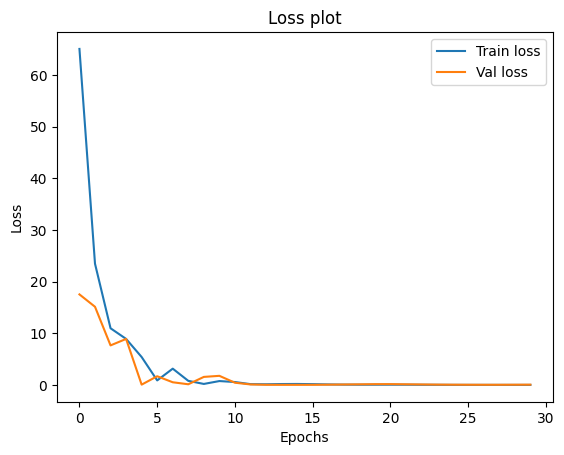

In [12]:
plt.title('Loss plot')
plt.plot(History['loss'])
plt.plot(History['val_loss'])
plt.legend(['Train loss', 'Val loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs');

In [13]:
y_pred = (model.predict(test_x).reshape(-1,)>=0.5).astype(int)
accuracy = np.sum(test_y==y_pred)/len(y_pred)

print("The model have an accuracy of:", accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 13s/step
The model have an accuracy of: 0.975


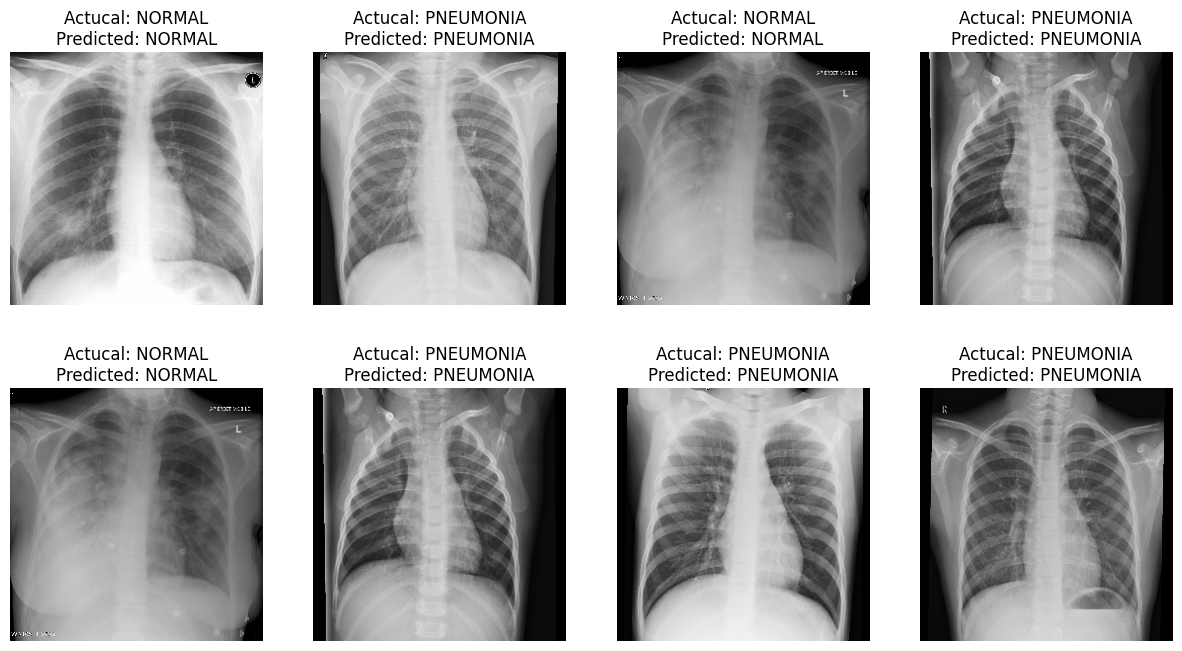

In [14]:
fig,ax= plt.subplots(2,4, figsize=(15, 8))
for i in range(2):
    for j in range(4):
        idx=2*i+j
        ax[i][j].imshow(test_x[idx])
        ax[i][j].axis('off')
        ax[i][j].set_title(f'Actucal: {label[test_y[idx]]}\nPredicted: {label[y_pred[idx]]}')

In [15]:
model.save('output/model.h5')